## 1. Data Splitting and Augmentation Strategy
The original dataset was first split into training, validation, and testing sets. Data augmentation and signal-level transformations were applied exclusively to the training portion to avoid any data leakage and to preserve the integrity of model evaluation.
- Original Dataset:
  - 20% test,
  - 20% validation,
  - 60% training
- Augmented Dataset:
  - 100% training
- **signal-level transformed Dataset**
  - From the 60% original training set.

Due to the dataset structure, exact parent-image mapping is unavailable; therefore, evaluation is performed on the separate original dataset to better approximate real-world performance.

## 2. Original Data Distribution Analysis
The original dataset comprised MRI images categorized into four classes based on the severity of Alzheimer's disease:
1. Non Demented
2. Very Mild Demented
3. Mild Demented
4. Moderate Demented

#### 2.1 Import Libraries

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

#### 2.2 Define Data Paths

In [2]:
DATASET_DIR = "../dataset/OriginalDataset"

#### 2.3 Analyze Data Distribution per Class

In [3]:
class_counts = []

for class_name in sorted(os.listdir(DATASET_DIR)):
    class_path = os.path.join(DATASET_DIR, class_name)

    if not os.path.isdir(class_path):
        continue

    image_files = [
        f for f in os.listdir(class_path)
        if f.lower().endswith((".jpg", ".jpeg", ".png"))
    ]

    class_counts.append({
        "Class": class_name,
        "Image_Count": len(image_files)
    })

#### 2.4 Create DataFrame and Visualize Distribution

In [4]:
df_distribution = pd.DataFrame(class_counts)

# 计算总数
total_images = df_distribution["Image_Count"].sum()

# 计算比例（百分比）
df_distribution["Percentage"] = (
    df_distribution["Image_Count"] / total_images * 100
).round(2)

df_distribution

,Class,Image_Count,Percentage
0,MildDemented,896,14.0
1,ModerateDemented,64,1.0
2,NonDemented,3200,50.0
3,VeryMildDemented,2240,35.0


/var/folders/qd/dymfl95s6qg48gd91br1c4700000gn/T/ipykernel_57065/3520414954.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_distribution["Class"], rotation=45)


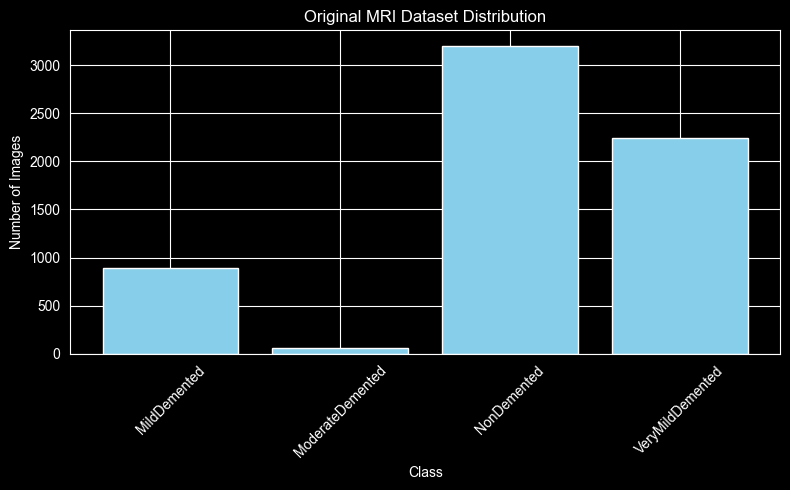

In [5]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(df_distribution["Class"], df_distribution["Image_Count"], color="skyblue")
ax.set_title("Original MRI Dataset Distribution")
ax.set_xlabel("Class")
ax.set_ylabel("Number of Images")
ax.set_xticklabels(df_distribution["Class"], rotation=45)
plt.tight_layout()
plt.show()

## 3. Split Original Dataset into Train, Validation, and Test Sets
The original dataset was split into three subsets to facilitate model training and evaluation:
- **Training Set**: 60% of the original dataset, used for model training and augmentation.
- **Validation Set**: 20% of the original dataset, used for hyperparameter tuning and model selection.
- **Test Set**: 20% of the original dataset, reserved for final model evaluation to assess generalization performance.

#### 3.1 Create DataFrame with Image Paths and Class Labels

In [6]:
records = []

for class_name in sorted(os.listdir(DATASET_DIR)):
    class_path = os.path.join(DATASET_DIR, class_name)

    if not os.path.isdir(class_path):
        continue

    for fname in os.listdir(class_path):
        if fname.lower().endswith((".jpg", ".jpeg", ".png")):
            records.append({
                "image_path": os.path.join(class_name, fname),
                "class": class_name
            })

df_original = pd.DataFrame(records)
df_original.head()

,image_path,class
0,MildDemented/mildDem678.jpg,MildDemented
1,MildDemented/mildDem650.jpg,MildDemented
2,MildDemented/mildDem136.jpg,MildDemented
3,MildDemented/mildDem122.jpg,MildDemented
4,MildDemented/mildDem644.jpg,MildDemented


#### 3.2 Split df into train, text, val sets with stratification to maintain class distribution

In [7]:
from sklearn.model_selection import train_test_split

df_train, df_temp = train_test_split(
    df_original,
    test_size=0.4,
    stratify=df_original["class"],
    random_state=42
)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3840 entries, 4943 to 596
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3840 non-null   object
 1   class       3840 non-null   object
dtypes: object(2)
memory usage: 90.0+ KB


In [8]:
df_val, df_test = train_test_split(
    df_temp,
    test_size=0.5,
    stratify=df_temp["class"],
    random_state=42
)
df_test.info(), df_val.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1280 entries, 5418 to 936
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  1280 non-null   object
 1   class       1280 non-null   object
dtypes: object(2)
memory usage: 30.0+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 1280 entries, 5373 to 5993
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  1280 non-null   object
 1   class       1280 non-null   object
dtypes: object(2)
memory usage: 30.0+ KB


(None, None)

In [9]:
df_train = df_train.copy()
df_val = df_val.copy()
df_test = df_test.copy()

df_train["split"] = "train"
df_val["split"] = "val"
df_test["split"] = "test"

df_manifest = pd.concat([df_train, df_val, df_test], ignore_index=True)
df_manifest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6400 entries, 0 to 6399
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  6400 non-null   object
 1   class       6400 non-null   object
 2   split       6400 non-null   object
dtypes: object(3)
memory usage: 150.1+ KB


In [10]:
OUTPUT_PATH = "original_split_manifest.csv"
df_manifest.to_csv(OUTPUT_PATH, index=False)

print(f"Split manifest saved to: {OUTPUT_PATH}")

Split manifest saved to: original_split_manifest.csv


## 4. Form training dataset

In [11]:
import tensorflow as tf

IMG_SIZE = (224, 224)
INPUT_SHAPE = (244, 244, 3)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
ORIGINAL_ROOT = "../dataset/OriginalDataset"
AUGMENTED_ROOT = "../dataset/AugmentedAlzheimerDataset"
MANIFEST_PATH = "./original_split_manifest.csv"

In [12]:
xception_preprocess = tf.keras.applications.xception.preprocess_input
def load_and_preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0  # normalize
    image = xception_preprocess(image)
    return image, label

#### 4.1 Define image preprocessing pipeline

In [13]:
def load_and_preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0  # normalize
    return image, label

#### 4.2 Get train data from original dataset

In [14]:
df_manifest = pd.read_csv(MANIFEST_PATH)
df_train = df_manifest[df_manifest["split"] == "train"].reset_index(drop=True)

In [15]:
class_names = sorted(df_train["class"].unique())
class_to_index = {name: idx for idx, name in enumerate(class_names)}

train_image_paths = [
    os.path.join(ORIGINAL_ROOT, row["image_path"])
    for _, row in df_train.iterrows()
]

train_labels = [
    class_to_index[row["class"]]
    for _, row in df_train.iterrows()
]

In [16]:
original_train_ds = tf.data.Dataset.from_tensor_slices(
    (train_image_paths, train_labels)
)

original_train_ds = (
    original_train_ds
    .map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
)

#### 4.3 Get train data from augmented dataset

In [17]:
aug_image_paths = []
aug_labels = []

for class_name in sorted(os.listdir(AUGMENTED_ROOT)):
    class_dir = os.path.join(AUGMENTED_ROOT, class_name)
    if not os.path.isdir(class_dir):
        continue

    for fname in os.listdir(class_dir):
        if fname.lower().endswith((".jpg", ".jpeg", ".png")):
            aug_image_paths.append(os.path.join(class_dir, fname))
            aug_labels.append(class_to_index[class_name])

In [18]:
augmented_ds = tf.data.Dataset.from_tensor_slices(
    (aug_image_paths, aug_labels)
)

augmented_ds = (
    augmented_ds
    .map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
)

#### 4.4 Signal-level Dataset from original training set

In [19]:
def signal_level_transform(image, label):
    # add Gaussian noise
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.03)
    image = image + noise

    # contrast adjustment
    image = tf.image.random_contrast(image, 0.9, 1.1)

    image = tf.clip_by_value(image, 0.0, 1.0)
    return image, label

In [20]:
signal_level_ds = original_train_ds.map(
    signal_level_transform,
    num_parallel_calls=AUTOTUNE
)

#### 4.5 Combine original, augmented, and signal-level datasets

In [21]:
training_ds = (
    original_train_ds
    .concatenate(augmented_ds)
    .concatenate(signal_level_ds)
)

In [22]:
training_ds = (
    training_ds
    .shuffle(1000)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

## 5. Class Imbalance Analysis
In the original MRI dataset, the class distribution is highly imbalanced (for example, “Moderate Demented” is much rarer than “Non Demented”). If we train a model without any imbalance strategy, the model may become biased toward majority classes and still achieve deceptively high accuracy, while performing poorly on minority classes. To reduce this bias, we apply imbalance handling only during training. The validation and test sets keep the original distribution to reflect real-world performance.

#### 5.1 Compute class distribution in Original-Train (60% split)
Measure the class distribution in the original training split (60% of the original dataset).
This tells us how severe the imbalance is and provides a reliable basis for computing class weights.
We intentionally compute these statistics before any augmentation, because evaluation is based on original data distribution.

,Class,Count,Percentage
0,MildDemented,538,14.01
1,ModerateDemented,38,0.99
2,NonDemented,1920,50.00
3,VeryMildDemented,1344,35.00


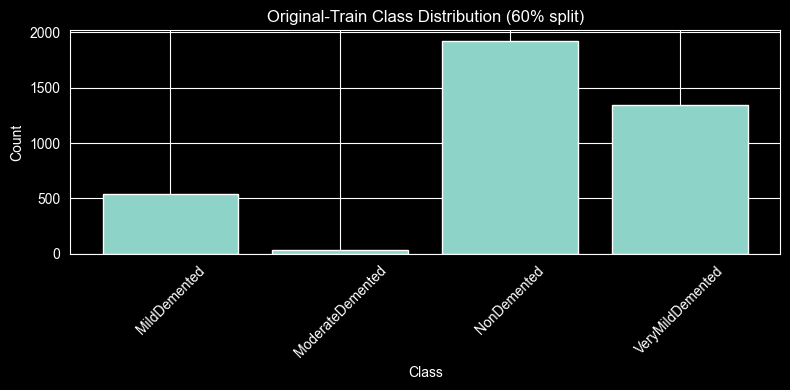

In [23]:
# Count class distribution in ORIGINAL train split (before any augmentation)
train_class_counts = df_train["class"].value_counts().sort_index()

train_class_counts_df = train_class_counts.reset_index()
train_class_counts_df.columns = ["Class", "Count"]
train_class_counts_df["Percentage"] = (
    train_class_counts_df["Count"] / train_class_counts_df["Count"].sum() * 100
).round(2)

display(train_class_counts_df)

# quick visualization
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(train_class_counts_df["Class"], train_class_counts_df["Count"])
ax.set_title("Original-Train Class Distribution (60% split)")
ax.set_xlabel("Class")
ax.set_ylabel("Count")
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

#### 5.2 Create class weights

Compute class weights from the original training split to increase the loss penalty for minority classes. This helps the model pay more attention to rare classes during training. Class weights do not change validation/test data; they only change how training loss is computed.

In [24]:
# Compute class weights from ORIGINAL train split (simple inverse-frequency)
total = int(train_class_counts.sum())
num_classes = int(len(train_class_counts))

# class_to_index is already defined earlier in your notebook
class_weight_dict = {
    class_to_index[class_name]: float(total / (num_classes * count))
    for class_name, count in train_class_counts.items()
}

print("Class weights (based on Original-Train):")
for class_idx in sorted(class_weight_dict.keys()):
    print(f"  class_index={class_idx}: weight={class_weight_dict[class_idx]:.4f}")

Class weights (based on Original-Train):
  class_index=0: weight=1.7844
  class_index=1: weight=25.2632
  class_index=2: weight=0.5000
  class_index=3: weight=0.7143


## 6. Form Validation and Test Datasets

In [25]:
# Load manifest and extract validation & test splits
df_manifest = pd.read_csv(MANIFEST_PATH)

df_val = df_manifest[df_manifest["split"] == "val"].reset_index(drop=True)
df_test = df_manifest[df_manifest["split"] == "test"].reset_index(drop=True)

print("Validation samples:", len(df_val))
print("Test samples:", len(df_test))

Validation samples: 1280
Test samples: 1280


#### 6.2 Reuse class mapping from training set

In [26]:
print("Class mapping:", class_to_index)

Class mapping: {'MildDemented': 0, 'ModerateDemented': 1, 'NonDemented': 2, 'VeryMildDemented': 3}


#### 6.3 Build file paths and labels for validation set

In [27]:
# Validation image paths and labels
val_image_paths = [
    os.path.join(ORIGINAL_ROOT, row["image_path"])
    for _, row in df_val.iterrows()
]

val_labels = [
    class_to_index[row["class"]]
    for _, row in df_val.iterrows()
]

#### 6.4 Build file paths and labels for test set

In [28]:
# Test image paths and labels
test_image_paths = [
    os.path.join(ORIGINAL_ROOT, row["image_path"])
    for _, row in df_test.iterrows()
]

test_labels = [
    class_to_index[row["class"]]
    for _, row in df_test.iterrows()
]

#### 6.5 Create tf.data.Dataset for validation

In [29]:
# Build validation dataset
val_ds = tf.data.Dataset.from_tensor_slices(
    (val_image_paths, val_labels)
)

val_ds = (
    val_ds
    .map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

#### 6.6 Create tf.data.Dataset for test

In [30]:
# Build test dataset
test_ds = tf.data.Dataset.from_tensor_slices(
    (test_image_paths, test_labels)
)

test_ds = (
    test_ds
    .map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

## 7. Build Model and Compile with Class Weights

In [31]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax

NUM_CLASSES = len(class_names)  # 4

base_model = tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_shape=INPUT_SHAPE,
    pooling="max"
)

base_model.trainable = False

model = Sequential([
    base_model,
    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.25),
    layers.Dense(NUM_CLASSES, activation="softmax")
])

model.compile(
    optimizer=Adamax(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 2048)           │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,124,268 (80.58 MB)

 Trainable params: 262,788 (1.00 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

## 8.Plot model graph

In [34]:
model.build(input_shape=(None, *INPUT_SHAPE))
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


## 9. Model Saving & Resume Training Logic

#### 9.1 Define paths and training control flags

In [35]:
import os
import json
import tensorflow as tf

MODEL_PATH = "models/alzheimer_xception_model.keras"
EPOCH_TRACKER_PATH = "models/epoch_tracker.json"

os.makedirs("models", exist_ok=True)

TOTAL_EPOCHS = 10
CONTINUE_TRAINING = True

#### 9.2 Load epoch tracker (for resume training)

In [36]:
if os.path.exists(EPOCH_TRACKER_PATH):
    with open(EPOCH_TRACKER_PATH, "r") as f:
        epoch_data = json.load(f)
        last_epoch = int(epoch_data.get("last_epoch", 0))
else:
    last_epoch = 0

print("Last completed epoch:", last_epoch)

Last completed epoch: 0


#### 9.3 Load existing model if available <br>
If a saved .keras model exists, we load and recompile it. Otherwise, we continue with the newly built model.

In [37]:
if os.path.exists(MODEL_PATH):
    print(f"Loading existing model from {MODEL_PATH}...")
    model = tf.keras.models.load_model(MODEL_PATH, compile=False)

    model.compile(
        optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    print("Model loaded and recompiled.")
else:
    print("No saved model found. Training a new model.")

No saved model found. Training a new model.


#### 9.4 Define AutoSave callback (epoch-level saving)

In [38]:
from tensorflow.keras.callbacks import Callback

class AutoSaveCallback(Callback):
    def __init__(self, model_path, tracker_path):
        super().__init__()
        self.model_path = model_path
        self.tracker_path = tracker_path

    def on_epoch_end(self, epoch, logs=None):
        self.model.save(self.model_path)
        with open(self.tracker_path, "w") as f:
            json.dump({"last_epoch": epoch + 1}, f)

        print(f"\n[AutoSave] Model saved to {self.model_path}")
        print(f"[AutoSave] Last epoch recorded: {epoch + 1}")

In [39]:
auto_save_cb = AutoSaveCallback(MODEL_PATH, EPOCH_TRACKER_PATH)

## 10.Train the Model (IMPORTANT: class_weight)

In [ ]:
history = None

if CONTINUE_TRAINING:
    if last_epoch >= TOTAL_EPOCHS:
        print(f"Training already completed ({last_epoch}/{TOTAL_EPOCHS} epochs).")
    else:
        print(f"Training from epoch {last_epoch} to {TOTAL_EPOCHS}...")

        history = model.fit(
            training_ds,
            validation_data=val_ds,
            epochs=TOTAL_EPOCHS,
            initial_epoch=last_epoch,
            callbacks=[auto_save_cb],
            class_weight=class_weight_dict  # ✅ IMPORTANT
        )
else:
    print("CONTINUE_TRAINING=False, skipping training.")

## 11. Evaluate on Test Set (Original Only)

In [ ]:
test_loss, test_accuracy = model.evaluate(test_ds, verbose=1)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

## 12. Predictions, Classification Report, Confusion Matrix

#### 12.1 Generate predictions

In [ ]:
import numpy as np

y_true = []
y_pred = []

for images, labels in test_ds:
    probs = model.predict(images, verbose=0)
    preds = np.argmax(probs, axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(preds)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

#### 12.2 Classification report <br>
For imbalanced datasets, macro-averaged precision, recall, and F1-score are more informative than accuracy alone.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
index_to_class = {v: k for k, v in class_to_index.items()}
target_names = [index_to_class[i] for i in range(len(class_names))]

print("Classification Report:")
print(
    classification_report(
        y_true,
        y_pred,
        target_names=target_names,
        digits=4
    )
)

#### 12.3 Confusion matrix visualization

In [ ]:
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix (Test Set)")
plt.colorbar()

ticks = np.arange(len(class_names))
plt.xticks(ticks, target_names, rotation=45)
plt.yticks(ticks, target_names)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

## 13 Plot Training Curves (if training occurred)

In [ ]:
if history is not None:
    plt.figure()
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.title("Accuracy Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title("Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

## 14. Final Save

In [ ]:
model.save(MODEL_PATH)
print(f"Final model saved to {MODEL_PATH}")